<a href="https://colab.research.google.com/github/carlosinator/cil-sentiment/blob/main/models_overview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
from google.colab import auth
auth.authenticate_user()

In [2]:
%%bash
pip3 install transformers emoji==0.6.0 keras_nlp tensorflow_probability

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 576.5/576.5 kB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 851.9/851.9 kB 65.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 85.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 55.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 90.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [3]:
import numpy as np
import pandas as pd
import sklearn
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import re
from pathlib import Path
import tensorflow as tf
import transformers

In [4]:
# reproducibility
transformers.set_seed(0) # sets the seed in random, numpy, and tf

# Data

In [5]:
# copy data to pwd
!gsutil cp "gs://cil_2023/train_pos_full_preprocessed_without_duplicates.txt" .
!gsutil cp "gs://cil_2023/train_neg_full_preprocessed_without_duplicates.txt" .

Copying gs://cil_2023/train_pos_full_preprocessed_without_duplicates.txt...
\ [1 files][ 74.6 MiB/ 74.6 MiB]                                                
Operation completed over 1 objects/74.6 MiB.                                     
Copying gs://cil_2023/train_neg_full_preprocessed_without_duplicates.txt...
/ [1 files][ 91.6 MiB/ 91.6 MiB]                                                
Operation completed over 1 objects/91.6 MiB.                                     


In [7]:
# define filenames
filename_train_pos = "train_pos_full_preprocessed_without_duplicates.txt"
filename_train_neg = "train_neg_full_preprocessed_without_duplicates.txt"

In [8]:
from transformers import AutoTokenizer, TFAutoModel, AutoConfig, TFAutoModelForSequenceClassification

# read dataset
dataset_pos_pd = pd.read_table(filename_train_pos, sep='\r\n', header=None, names=['text'])
dataset_neg_pd = pd.read_table(filename_train_neg, sep='\r\n', header=None, names=['text'])
dataset_pos_pd['label'] = 0
dataset_neg_pd['label'] = 1
dataset_pd = pd.concat([dataset_pos_pd, dataset_neg_pd])

# shuffle
dataset_pd = dataset_pd.sample(frac=1, random_state=0).reset_index(drop=True)

# tokenize data set
model_name = "vinai/bertweet-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
texts = tokenizer.batch_encode_plus(dataset_pd['text'].tolist(),
                                    padding=True, truncation=True,
                                    return_tensors='tf')

dataset = tf.data.Dataset.from_tensor_slices((dict(texts), dataset_pd['label']))

<ipython-input-8-854d5865ecc4>:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  dataset_pos_pd = pd.read_table(filename_train_pos, sep='\r\n', header=None, names=['text'])
<ipython-input-8-854d5865ecc4>:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  dataset_neg_pd = pd.read_table(filename_train_neg, sep='\r\n', header=None, names=['text'])


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [9]:
# split training / validation
AUTOTUNE = tf.data.experimental.AUTOTUNE

val_data_size = int(0.1 * len(dataset_pd.index))
test_data_size = int(0.1 * len(dataset_pd.index))
train_data_size = len(dataset_pd.index) - val_data_size - test_data_size

In [10]:
def get_test_ds(batch_size: int):
  val_ds = dataset.take(val_data_size).batch(batch_size, drop_remainder=True)
  train_ds = dataset.skip(val_data_size).take(train_data_size).batch(batch_size, drop_remainder=True)
  test_ds = dataset.skip(val_data_size + train_data_size).take(test_data_size).batch(batch_size, drop_remainder=True)

  train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

  return test_ds

# Models

In [11]:
# helper function
def remove_trailing_zeros(array):
    last_index = len(array) - 1

    # Find the last non-zero element
    while last_index >= 0 and array[last_index] == 0:
        last_index -= 1

    # Resize the array to exclude trailing zeros
    array = array[0:last_index + 1]

    return array

In [12]:
from dataclasses import dataclass
from typing import List
from enum import Enum
import os
from pathlib import Path
from functools import cached_property

class ExperimentType(Enum):
    READ = "read"
    MINION = "minion"
    BASE = "base"

@dataclass
class Experiment:
    name: str
    lr: float
    units: int
    batch_size: int
    epochs: int
    type_id: ExperimentType
    _cached_predictions: dict = None

    @property
    def description(self) -> str:
      gru_description = f"GRU_UNITS: {self.units}"
      return f"{self.type_id.value.upper()} (EPOCHS: {self.epochs}, LR: {self.lr}, BATCH_SIZE: {self.batch_size}{', '+gru_description if gru_description else ''})"

    def base_filename(self) -> str:
        type_id_string = ""
        if self.type_id == ExperimentType.READ:
            type_id_string = "paper-read"
        elif self.type_id == ExperimentType.MINION:
            type_id_string = "read"
        elif self.type_id == ExperimentType.BASE:
            type_id_string = "basemodel"

        return f"inference_{type_id_string}_fullmodel_lr{self.lr}_ep{self.epochs}_batchs={self.batch_size}_gru_units={self.units}"

    @cached_property
    def model(self):
        if not Path(self.base_filename()).exists():
          !gsutil cp -r {"gs://cil_2023/models/" + self.base_filename()} .
        return tf.keras.models.load_model(self.base_filename())

    @cached_property
    def gpu_history(self):
      gpu_file_name = f"gpu_hist_{self.base_filename()}.pkl"

      if not Path(gpu_file_name).exists():
        fname = "gs://cil_2023/models/" + gpu_file_name
        !gsutil cp $fname .

      with open(gpu_file_name, 'rb') as file:
        # Load the pickled object
        unpickled_object = pickle.load(file)

        # remove trailing zeros (due to some bugs, this may occur, if gpu measurement does not automatically stop)
        unpickled_object["percent"] = remove_trailing_zeros(unpickled_object["percent"])

        return unpickled_object

    def prediction_filename(self) -> str:
        return f"{self.base_filename()}_prediction.npy"

    def cache_predictions(self, labels: np.array, predictions: np.array) -> None:
        file_name = self.prediction_filename()
        prediction_dict = {"labels": labels, "predictions": predictions}

        with open(file_name, 'wb') as f:
            np.save(f, prediction_dict)

        !gsutil cp $file_name gs://cil_2023/prediction_cache/
        print(f"Predictions cached successfully to gs://cil_2023/prediction_cache/{file_name}")
        self._cached_predictions = prediction_dict

    @property
    def cached_predictions(self):
        if self._cached_predictions is not None:
            return self._cached_predictions["labels"],  self._cached_predictions["predictions"]

        file_name = self.prediction_filename()
        gcs_path = f"gs://cil_2023/prediction_cache/{file_name}"

        # Check if the file exists in GCS bucket
        exist_status = os.system(f"gsutil -q stat {gcs_path}")

        if exist_status == 0:
            # file exists in cloud bucket
            if not Path(file_name).exists():
                !gsutil cp $gcs_path .

            with open(file_name, 'rb') as f:
                prediction_dict = np.load(f, allow_pickle=True).item()

            self._cached_predictions = prediction_dict  # Cache the predictions
            return self._cached_predictions["labels"],  self._cached_predictions["predictions"]
        else:
            print("Cache is empty, no predictions available")
            return None

In [13]:
# Helper function
def sort_experiments(experiments: List[Experiment]) -> List[Experiment]:
    def sorting_key(experiment):
        type_order = {
            ExperimentType.BASE: 0,
            ExperimentType.READ: 1,
            ExperimentType.MINION: 2
        }
        # First sorting criterion: type_id
        primary_sort = type_order[experiment.type_id]

        # Second sorting criterion: units (number of units)
        secondary_sort1 = experiment.units

        # Third sorting criterion: lr (learning rate)
        secondary_sort2 = experiment.lr

        # Fourth sorting criterion: batch_size
        secondary_sort3 = experiment.batch_size

        # Fifth sorting criterion: epochs
        secondary_sort4 = experiment.epochs

        return (primary_sort, secondary_sort1, secondary_sort2, secondary_sort3, secondary_sort4)

    return sorted(experiments, key=sorting_key)

In [14]:
# List of experiments
EXPERIMENTS: List[Experiment] = [
    Experiment(name="basemodel", lr=2e-5, units=32, batch_size=256, epochs=5, type_id=ExperimentType.BASE),
    Experiment(name="minion_v0", lr=1e-3, units=64, batch_size=256, epochs=5, type_id=ExperimentType.MINION),
    Experiment(name="minion_v1", lr=1e-3, units=8, batch_size=256, epochs=5, type_id=ExperimentType.MINION),
    Experiment(name="paperread_v0", lr=1e-3, units=64, batch_size=256, epochs=5, type_id=ExperimentType.READ),
    Experiment(name="minion_v2", lr=3e-4, units=64, batch_size=256, epochs=5, type_id=ExperimentType.MINION),
    Experiment(name="minion_v3", lr=3e-4, units=8, batch_size=256, epochs=5, type_id=ExperimentType.MINION),
    Experiment(name="paperread_v1", lr=1e-3, units=256, batch_size=256, epochs=5, type_id=ExperimentType.READ),
    Experiment(name="minion_v4", lr=3e-4, units=16, batch_size=256, epochs=5, type_id=ExperimentType.MINION),
    #Experiment(name="paperread_v2", lr=2e-4, units=256, batch_size=256, epochs=5, type_id=ExperimentType.READ),
    Experiment(name="paperread_v3", lr=1e-3, units=32, batch_size=256, epochs=5, type_id=ExperimentType.READ),
    Experiment(name="minion_v5", lr=1e-3, units=256, batch_size=256, epochs=5, type_id=ExperimentType.MINION),
    #Experiment(name="minion_v6", lr=1e-3, units=512, batch_size=256, epochs=5, type_id=ExperimentType.MINION),
    Experiment(name="paperread_v4", lr=1e-3, units=8, batch_size=256, epochs=5, type_id=ExperimentType.READ),
    Experiment(name="paperread_v5", lr=3e-4, units=8, batch_size=256, epochs=5, type_id=ExperimentType.READ),
    Experiment(name="paperread_v6", lr=3e-4, units=64, batch_size=256, epochs=5, type_id=ExperimentType.READ),
    Experiment(name="paperread_v6", lr=3e-4, units=16, batch_size=256, epochs=5, type_id=ExperimentType.READ),
    Experiment(name="minion_v7", lr=1e-3, units=16, batch_size=256, epochs=5, type_id=ExperimentType.MINION),
    Experiment(name="minion_v8", lr=3e-4, units=256, batch_size=256, epochs=5, type_id=ExperimentType.MINION),
    Experiment(name="paperread_v7", lr=3e-4, units=256, batch_size=256, epochs=5, type_id=ExperimentType.READ),
    Experiment(name="minion_v9", lr=3e-4, units=32, batch_size=256, epochs=5, type_id=ExperimentType.MINION),
    Experiment(name="paperread_v8", lr=3e-4, units=32, batch_size=256, epochs=5, type_id=ExperimentType.READ),
    Experiment(name="minion_v10", lr=1e-3, units=32, batch_size=256, epochs=5, type_id=ExperimentType.MINION),
    Experiment(name="minion_v11", lr=3e-4, units=128, batch_size=256, epochs=5, type_id=ExperimentType.MINION),
    Experiment(name="paperread_v9", lr=1e-3, units=16, batch_size=256, epochs=5, type_id=ExperimentType.READ),
    Experiment(name="minion_v12", lr=1e-3, units=128, batch_size=256, epochs=5, type_id=ExperimentType.MINION),
    Experiment(name="paperread_v10", lr=3e-4, units=128, batch_size=256, epochs=5, type_id=ExperimentType.READ),
    Experiment(name="paperread_v11", lr=1e-3, units=128, batch_size=256, epochs=5, type_id=ExperimentType.READ),
]

def check_for_duplicates(experiments: List[Experiment]) -> None:
    experiment_configs = set()

    for experiment in experiments:
        # create a tuple of experiment attributes excluding name
        config = (experiment.type_id, experiment.lr, experiment.units, experiment.batch_size, experiment.epochs)

        if config in experiment_configs:
            raise ValueError(f"Duplicate experiment configuration found: {config}")
        else:
            experiment_configs.add(config)

check_for_duplicates(EXPERIMENTS) # sanitize

def get_experiment(name: str) -> Experiment:
    for experiment in EXPERIMENTS:
        if experiment.name == name:
            return experiment
    return None

In [15]:
def check_experiment_exists(
    type_id: ExperimentType,
    lr: float,
    units: int,
    batch_size: int,
    epochs: int
) -> bool:
    for experiment in EXPERIMENTS:
        if (
            experiment.type_id == type_id and
            experiment.lr == lr and
            experiment.units == units and
            experiment.batch_size == batch_size and
            experiment.epochs == epochs
        ):
            return True

    return False

In [16]:
# possibly new experiment:
#if check_experiment_exists(
#    type_id = ExperimentType.READ,
#    lr = 3e-4,
#    units = 64,
#    batch_size = 256,
#    epochs = 5
#):
#  raise ValueError(f"Already exists!!!")


# Making predictions

In [17]:
from tqdm import tqdm

def get_predictions(experiment: Experiment, overwrite_cache = False):
  if (not overwrite_cache) and (experiment.cached_predictions is not None):
    return experiment.cached_predictions

  # otherwise make predictions
  model = experiment.model
  test_ds = get_test_ds(experiment.batch_size)

  # DEBUG (Only first 3 batches)
  #test_ds = get_test_ds(experiment.batch_size).take(3)

  # Assuming that 'model' is your trained model
  # Assuming that 'dataset' is your batched dataset

  # These lists will store all labels and predictions
  all_labels = []
  all_predictions = []

  # Iterate over batches in the dataset
  with tqdm(total=np.sum([1 for _ in test_ds]), dynamic_ncols=True) as pbar:
    for features, labels in test_ds:
        # Predict the outputs for the current batch (in silent mode)
        batch_predictions = model.predict(features, verbose=0)

        # if predictions are logits, put them through softmax
        if isinstance(batch_predictions, dict) and "logits" in batch_predictions:
          logits_value = batch_predictions["logits"]
          probabilities = tf.keras.layers.Softmax()(logits_value)
          batch_predictions = probabilities.numpy()

        # Flatten labels and add them to their respective lists
        all_labels.extend(labels.numpy().flatten())
        # Save the batch predictions
        all_predictions.extend(batch_predictions)

        # Update the progress bar
        pbar.update()

  # Convert list of predictions to numpy array
  all_predictions = np.array(all_predictions)

  # cache predictions
  experiment.cache_predictions(all_labels, all_predictions)

  # return predictions
  return all_labels, all_predictions


In [18]:
# code, to cache all predictions for all experiments
for i, experiment in enumerate(EXPERIMENTS):
  print(f"🔮 ({i+1}/{len(EXPERIMENTS)}) Making predictions for experiment: {experiment.description}")
  get_predictions(experiment, overwrite_cache=False) # modify to overwrite cache or not

  print("\n")

🔮 (1/25) Making predictions for experiment: BASE (EPOCHS: 5, LR: 2e-05, BATCH_SIZE: 256, GRU_UNITS: 32)
Copying gs://cil_2023/prediction_cache/inference_basemodel_fullmodel_lr2e-05_ep5_batchs=256_gru_units=32_prediction.npy...
\ [1 files][  8.4 MiB/  8.4 MiB]                                                
Operation completed over 1 objects/8.4 MiB.                                      


🔮 (2/25) Making predictions for experiment: MINION (EPOCHS: 5, LR: 0.001, BATCH_SIZE: 256, GRU_UNITS: 64)
Copying gs://cil_2023/prediction_cache/inference_read_fullmodel_lr0.001_ep5_batchs=256_gru_units=64_prediction.npy...
\ [1 files][  8.4 MiB/  8.4 MiB]                                                
Operation completed over 1 objects/8.4 MiB.                                      


🔮 (3/25) Making predictions for experiment: MINION (EPOCHS: 5, LR: 0.001, BATCH_SIZE: 256, GRU_UNITS: 8)
Copying gs://cil_2023/prediction_cache/inference_read_fullmodel_lr0.001_ep5_batchs=256_gru_units=8_prediction.npy.

100%|██████████| 886/886 [07:19<00:00,  2.01it/s]


Copying file://inference_paper-read_fullmodel_lr0.001_ep5_batchs=256_gru_units=128_prediction.npy [Content-Type=application/octet-stream]...
-
Operation completed over 1 objects/8.4 MiB.                                      
Predictions cached successfully to gs://cil_2023/prediction_cache/inference_paper-read_fullmodel_lr0.001_ep5_batchs=256_gru_units=128_prediction.npy




# Metrics

## GPU States

In [19]:
A100_p0 = 0.4 # see here for SXM: https://www.nvidia.com/en-us/data-center/a100/
DEFAULT_ENERYG_P0 = A100_p0

In [37]:
def get_duration(experiment: Experiment):
  gpu_hist = experiment.gpu_history
  percent_values = gpu_hist["percent"]
  interval = gpu_hist["interval"]

  total_time_seconds = len(percent_values) * interval

  # Convert total_time_seconds to hours and minutes
  total_time_minutes, seconds = divmod(total_time_seconds, 60)
  hours, minutes = divmod(total_time_minutes, 60)

  #print(f"Total time measured: {total_time_seconds} seconds")
  #print(f"Total time measured: {hours} hours and {minutes} minutes")
  #print(f"Total time measured: {total_time_minutes} minutes and {seconds} seconds")

  # Calculate average time per epoch
  if experiment.epochs > 0:
      average_time_per_epoch_seconds = total_time_seconds / experiment.epochs
      avg_time_minutes, avg_time_seconds = divmod(average_time_per_epoch_seconds, 60)
      avg_time_hours, avg_time_minutes = divmod(avg_time_minutes, 60)
      #print(f"Average time per epoch: {avg_time_hours} hours and {avg_time_minutes} minutes and {avg_time_seconds:.2f} seconds")


  return total_time_seconds, hours, minutes, average_time_per_epoch_seconds

def compute_energy_consumption(experiment: Experiment, p0: float = DEFAULT_ENERYG_P0):
  gpu_hist = experiment.gpu_history
  utilization_percents = gpu_hist["percent"]
  interval = gpu_hist["interval"]

  # Calculate the number of entries per minute
  entries_per_minute = (int)(60 // interval)

  # Check if the utilization_percents length is a multiple of entries_per_minute
  # If not, it means the last minute is incomplete, and we should only consider complete minutes for the calculation
  if len(utilization_percents) % entries_per_minute != 0:
      drop_count = (int)(len(utilization_percents) % entries_per_minute)
      utilization_percents = utilization_percents[:-drop_count]

  # Reshape the utilization_percents to a 2D array with 'entries_per_minute' columns
  utilization_percents = np.array(utilization_percents).reshape(-1, entries_per_minute)

  # Create utilization_percents_per_minutes list by taking the average of each row
  utilization_percents_per_minutes = utilization_percents.mean(axis=1)


  # Compute the total energy consumption
  total_energy_consumption = np.sum(utilization_percents_per_minutes) * p0 / 6000

  # result is in kWH
  return total_energy_consumption

def compute_energy_consumption_v2(experiment: Experiment, p0: float = DEFAULT_ENERYG_P0):
  duration_s, _, _, _ = get_duration(experiment)

  # get history
  gpu_hist = experiment.gpu_history
  utilization_percents = gpu_hist["percent"]
  interval = gpu_hist["interval"]

  # floor duration to a multiple of interval
  duration_s = (duration_s // interval) * interval

  # get duration in hours
  duration_h = duration_s / 3600.0

  # formula from paper
  #return (p0 / (36000 * duration_h)) * np.sum(utilization_percents)
  return (p0 / (36000)) * np.sum(utilization_percents)

def compute_average_gpu_memory(experiment: Experiment, unit: str = "MiB"):
  gpu_hist = experiment.gpu_history
  memory_mib = gpu_hist["mib"]

  # Calculate average by summing all values and dividing by count of values
  average_memory_mib = sum(memory_mib) / len(memory_mib)

  if unit == 'GiB':
      # Convert MiB to GiB by dividing by 1024
      return average_memory_mib / 1024
  elif unit == 'MiB':
      return average_memory_mib
  else:
      raise ValueError("Invalid unit. Please choose either 'MiB' or 'GiB'")



## Accuracy

In [21]:
import sklearn.metrics

def get_scoring(experiment: Experiment, overwrite_cache=False):
  all_labels, all_predictions = get_predictions(experiment, overwrite_cache=overwrite_cache)

  # Use argmax to get the class with the highest probability for each prediction
  all_predictions_labels = np.argmax(all_predictions, axis=-1)

  # Now we can compute the accuracy and F1 score
  accuracy = sklearn.metrics.accuracy_score(all_labels, all_predictions_labels)
  f1 = sklearn.metrics.f1_score(all_labels, all_predictions_labels, average='macro')

  #print("Model accuracy:", accuracy)
  #print("Model F1 score:", f1)

  return accuracy, f1, all_labels, all_predictions

## Calibration

In [22]:
import tensorflow_probability as tfp
import sklearn.calibration

# define the default number of bins
NUM_BINS = 20

def get_expected_calibration_error(experiment: Experiment, num_bins = NUM_BINS):
    labels, predictions = get_predictions(experiment)
    predicted_labels = np.argmax(predictions, axis=-1).astype(np.int32)

    # make labels 32 bit integer, to match 32 bit integer in predicted labes
    labels = np.array(labels, dtype=np.int32)

    ece = tfp.stats.expected_calibration_error(
        num_bins=num_bins,
        logits=np.log(predictions), # logits!
        labels_predicted=predicted_labels,
        labels_true=labels
    )

    return ece.numpy()  # convert tensor to numpy array

def get_calibration_curve(experiment: Experiment, num_bins = NUM_BINS):
    labels, predictions = get_predictions(experiment)

    return sklearn.calibration.calibration_curve(y_true=labels, y_prob=predictions[:,0], pos_label=0, n_bins=num_bins)

def get_calibration_display(experiment: Experiment, num_bins = NUM_BINS, title: str = None):
    labels, predictions = get_predictions(experiment)

    plot_title = experiment.description if title is None else title

    # Create a new figure and axes
    fig, ax = plt.subplots()

    # Apply the title to the axes
    ax.set_title(plot_title)

    disp = sklearn.calibration.CalibrationDisplay.from_predictions(y_true=labels, y_prob=predictions[:,0], pos_label=0, n_bins=num_bins, ax=ax)

    return disp, ax

def get_max_calibration_error(experiment: Experiment, num_bins = NUM_BINS):
    true_proportion, predicted_proportion = get_calibration_curve(experiment, num_bins)

    mce = np.max(np.abs(true_proportion - predicted_proportion))
    return mce

# Tests

In [61]:
experiment = get_experiment("minion_v0")
get_duration(experiment)

Total time measured: 8490.0 seconds
Total time measured: 2.0 hours and 21.0 minutes
Total time measured: 141.0 minutes and 30.0 seconds
Average time per epoch: 0.0 hours and 28.0 minutes and 18.00 seconds


(8490.0, 2.0, 21.0)

In [117]:
experiment = get_experiment("minion_v0")
experiment.base_filename()
scores = get_scoring(experiment, overwrite_cache=False)

Model accuracy: 0.8971354166666666
Model F1 score: 0.8971268704166843


In [79]:
experiment = get_experiment("basemodel")
experiment.base_filename()
scores = get_scoring(experiment)

100%|██████████| 3/3 [00:04<00:00,  1.60s/it]

Model accuracy: 0.9674479166666666
Model F1 score: 0.9674014360346563


In [152]:
## compute scores for all experiments
for experiment in sort_experiments(EXPERIMENTS):
  print(f"model name: {experiment.description}")
  acc, f1sc, _ , _  = get_scoring(experiment)
  print(f"...accuracy: {acc}")
  print(f"...f1 score: {f1sc}")

model name: BASE (EPOCHS: 5, LR: 2e-05, BATCH_SIZE: 256, GRU_UNITS: 32)
...accuracy: 0.9753456546275395
...f1 score: 0.9753423444207174
model name: READ (EPOCHS: 5, LR: 0.001, BATCH_SIZE: 256, GRU_UNITS: 64)
...accuracy: 0.9115274054740407
...f1 score: 0.9115171908453072
model name: READ (EPOCHS: 5, LR: 0.001, BATCH_SIZE: 256, GRU_UNITS: 256)
...accuracy: 0.9218926354401806
...f1 score: 0.9218703812298172
model name: READ (EPOCHS: 5, LR: 0.0002, BATCH_SIZE: 256, GRU_UNITS: 256)
...accuracy: 0.9067129303047404
...f1 score: 0.9066673390355137
model name: MINION (EPOCHS: 5, LR: 0.001, BATCH_SIZE: 256, GRU_UNITS: 64)
...accuracy: 0.9069377821670429
...f1 score: 0.9069242785402416
model name: MINION (EPOCHS: 5, LR: 0.001, BATCH_SIZE: 256, GRU_UNITS: 8)
...accuracy: 0.8979040279345373
...f1 score: 0.897871288855697
model name: MINION (EPOCHS: 5, LR: 0.0003, BATCH_SIZE: 256, GRU_UNITS: 64)
...accuracy: 0.9091818919300225
...f1 score: 0.9091793624836717
model name: MINION (EPOCHS: 5, LR: 0.000

# Experiment Overview Table
We will generate a table with an overview of all experiments

In [48]:

def create_experiment_dataframe(experiments):
    # sort experiments
    experiments = sort_experiments(experiments)

    # Initialize lists for each column
    model_type = []
    learning_rate = []
    num_units = []
    batch_size = []
    epochs = []
    trainable_parameters = []
    total_parameters = []
    trainable_parameters_percent = []
    accuracy = []
    f1_score = []
    ece = []
    mce = []
    training_duration = []
    average_training_time_per_epoch = []
    energy_consumption = []
    energy_consumption_v2 = []
    power = []
    gpu_memory_usage_mib = []
    gpu_memory_usage_gib = []

    for experiment in experiments:
        # Append data to lists
        model_type.append(experiment.type_id.value.upper())
        learning_rate.append(experiment.lr)
        num_units.append(0 if experiment.type_id == ExperimentType.BASE else experiment.units) # do never display units for base model
        batch_size.append(experiment.batch_size)
        epochs.append(experiment.epochs)

        # Retrieve tensorflow model
        model = experiment.model
        trainable_parameters.append(np.sum([tf.size(v) for v in model.trainable_variables]))
        total_parameters.append(model.count_params())
        trainable_parameters_percent.append((trainable_parameters[-1]/total_parameters[-1])*100)

        # Get scoring
        acc, f1, _, _ = get_scoring(experiment)
        accuracy.append(acc)
        f1_score.append(f1)

        # Get calibration stuff
        ece.append(get_expected_calibration_error(experiment))
        mce.append(get_max_calibration_error(experiment))

        # Get duration and energy consumption
        duration, _, _, average_time_per_epoch = get_duration(experiment)
        training_duration.append(duration / 60)
        average_training_time_per_epoch.append(average_time_per_epoch / 60)
        energy = compute_energy_consumption(experiment)
        energy_v2 = compute_energy_consumption_v2(experiment)
        energy_consumption.append(energy)
        energy_consumption_v2.append(energy_v2)
        power.append(energy / (duration / 3600))  # Convert seconds to hours

        # GPU memory usage
        mem_mib = compute_average_gpu_memory(experiment, unit="MiB")
        mem_gib = compute_average_gpu_memory(experiment, unit="GiB")
        gpu_memory_usage_mib.append(mem_mib)
        gpu_memory_usage_gib.append(mem_gib)

    # Create DataFrame
    df = pd.DataFrame({
        'Model Type': model_type,
        'Learning Rate': learning_rate,
        'Number of Units': num_units,
        'Batch Size': batch_size,
        'Number of Epochs': epochs,
        'Trainable Parameters': trainable_parameters,
        'Total Parameters': total_parameters,
        'Trainable Parameters (%)': trainable_parameters_percent,
        'Accuracy': accuracy,
        'F1 Score': f1_score,
        'ECE': ece,
        'MCE': mce,
        'Training Duration (min)': training_duration,
        'Average Training Time Per Epoch (min)': average_training_time_per_epoch,
        'Energy Consumption (kWh)': energy_consumption,
        'Energy Consumption v2 (kWh)': energy_consumption_v2,
        'Power (KW)': power,
        'Average GPU Memory usage (MiB)': gpu_memory_usage_mib,
        'Average GPU Memory usage (GiB)': gpu_memory_usage_gib,
    })

    # Format Learning Rate column with scientific notation with one digit after the decimal point
    df['Learning Rate'] = df['Learning Rate'].map('{:.1e}'.format)

    # Format Trainable Parameters and Total Parameters with commas for thousands
    #df['Trainable Parameters'] = df['Trainable Parameters'].map('{:,}'.format)
    df['Trainable Parameters'] = df['Trainable Parameters'].map('{:.2e}'.format)
    #df['Total Parameters'] = df['Total Parameters'].map('{:,}'.format)
    df['Total Parameters'] = df['Total Parameters'].map('{:.2e}'.format)
    df['Trainable Parameters (%)'] = df['Trainable Parameters (%)'].map('{:.2f}%'.format)

    # Format Accuracy and F1 Score with four digits after the decimal point
    df['Accuracy'] = df['Accuracy'].map('{:.4f}'.format)
    df['F1 Score'] = df['F1 Score'].map('{:.4f}'.format)

    # Format ece and mce
    df['ECE'] = df['ECE'].map('{:.2e}'.format)
    df['MCE'] = df['MCE'].map('{:.2e}'.format)


    # Format Training Duration, Average Training time per epoch, Energy Consumption, and Power with two digits after the decimal point
    df['Training Duration (min)'] = df['Training Duration (min)'].map('{:.2f}'.format)
    df['Average Training Time Per Epoch (min)'] = df['Average Training Time Per Epoch (min)'].map('{:.2f}'.format)
    df['Energy Consumption (kWh)'] = df['Energy Consumption (kWh)'].map('{:.5f}'.format)
    df['Energy Consumption v2 (kWh)'] = df['Energy Consumption v2 (kWh)'].map('{:.5f}'.format)
    df['Power (KW)'] = df['Power (KW)'].map('{:.2f}'.format)

    # Format for GPU memory usage
    df['Average GPU Memory usage (MiB)'] = df['Average GPU Memory usage (MiB)'].map('{:,.2f}'.format)
    df['Average GPU Memory usage (GiB)'] = df['Average GPU Memory usage (GiB)'].map('{:,.2f}'.format)

    return df

In [49]:
# show the table
create_experiment_dataframe(EXPERIMENTS)

,Model Type,Learning Rate,Number of Units,Batch Size,Number of Epochs,Trainable Parameters,Total Parameters,Trainable Parameters (%),Accuracy,F1 Score,ECE,MCE,Training Duration (min),Average Training Time Per Epoch (min),Energy Consumption (kWh),Energy Consumption v2 (kWh),Power (KW),Average GPU Memory usage (MiB),Average GPU Memory usage (GiB)
0,BASE,2.0e-05,0,256,5,1.35e+08,1.35e+08,100.00%,0.9753,0.9753,1.27e-02,1.73e-01,244.33,48.87,1.58117,1.58122,0.39,"33,847.04",33.05
1,READ,3.0e-04,8,256,5,4.35e+04,1.35e+08,0.03%,0.8946,0.8946,1.61e-02,3.51e-02,163.33,32.67,0.88777,0.88991,0.33,"9,385.86",9.17
2,READ,1.0e-03,8,256,5,4.35e+04,1.35e+08,0.03%,0.8984,0.8984,1.11e-02,6.21e-02,164.17,32.83,0.88684,0.88687,0.32,"5,348.63",5.22
3,READ,3.0e-04,16,256,5,8.78e+04,1.35e+08,0.07%,0.8962,0.8962,9.56e-03,7.43e-02,162.33,32.47,0.87801,0.88003,0.32,"5,351.04",5.23
4,READ,1.0e-03,16,256,5,8.78e+04,1.35e+08,0.07%,0.9026,0.9026,9.66e-03,6.05e-02,163.33,32.67,0.88234,0.88440,0.32,"5,351.23",5.23
5,READ,3.0e-04,32,256,5,1.79e+05,1.35e+08,0.13%,0.9003,0.9003,9.34e-03,8.73e-02,167.33,33.47,0.89299,0.89507,0.32,"9,387.50",9.17
6,READ,1.0e-03,32,256,5,1.79e+05,1.35e+08,0.13%,0.9067,0.9067,9.22e-03,6.66e-02,167.17,33.43,0.89089,0.89189,0.32,"9,387.95",9.17
7,READ,3.0e-04,64,256,5,3.70e+05,1.35e+08,0.27%,0.9039,0.9039,6.81e-03,8.33e-02,165.17,33.03,0.94264,0.94370,0.34,"9,387.30",9.17
8,READ,1.0e-03,64,256,5,3.70e+05,1.35e+08,0.27%,0.9115,0.9115,1.11e-02,4.84e-02,164.83,32.97,0.93750,0.94283,0.34,"9,387.02",9.17
9,READ,3.0e-04,128,256,5,7.88e+05,1.36e+08,0.58%,0.9076,0.9076,8.94e-03,8.15e-02,169.50,33.90,0.97584,0.97902,0.35,"9,393.12",9.17


# Plots

## Calibration Display


<ipython-input-22-6a2efbcfc8a2>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


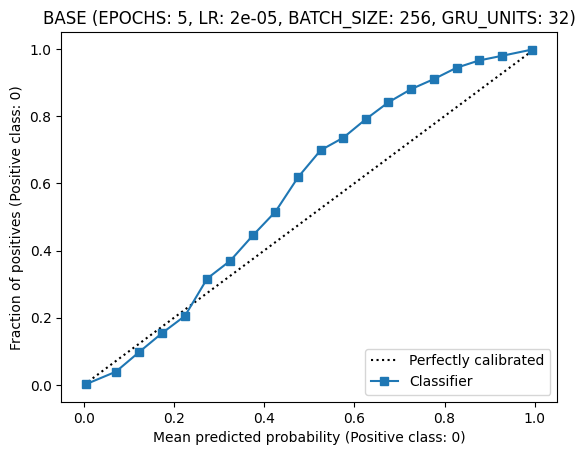

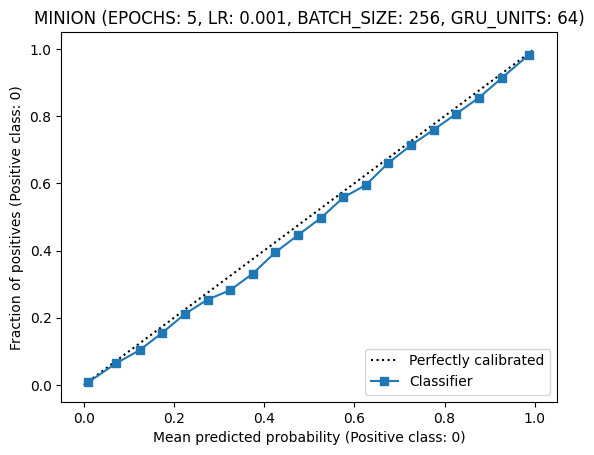

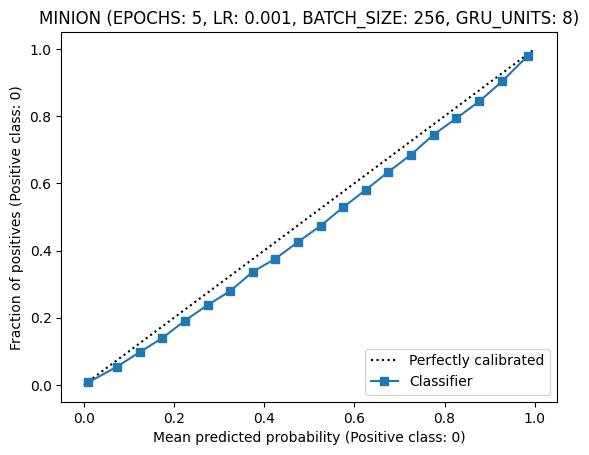

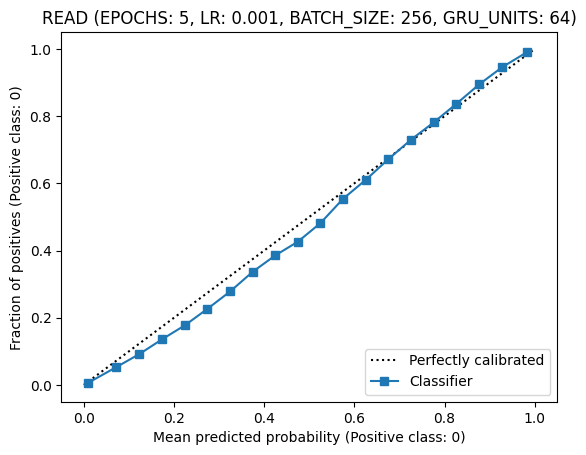

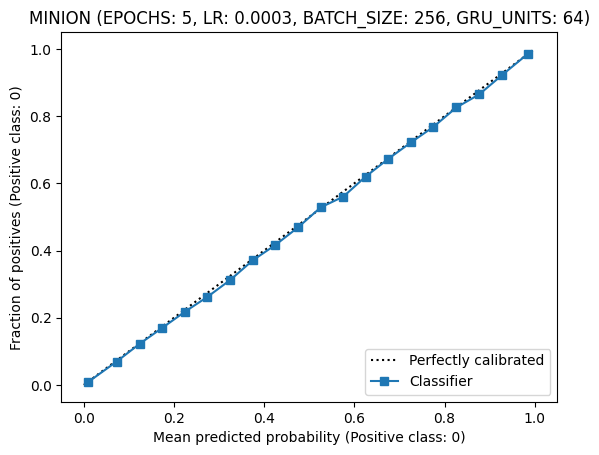

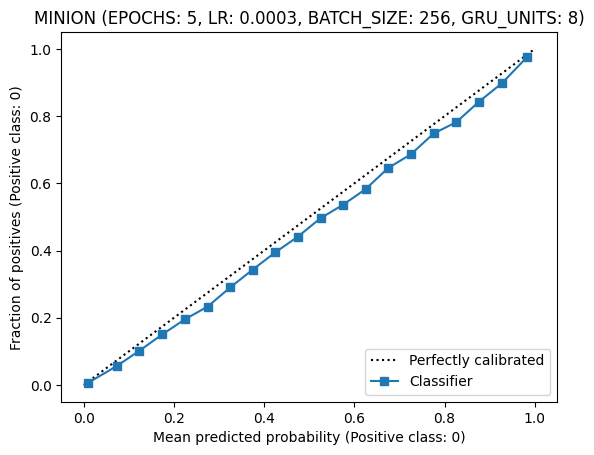

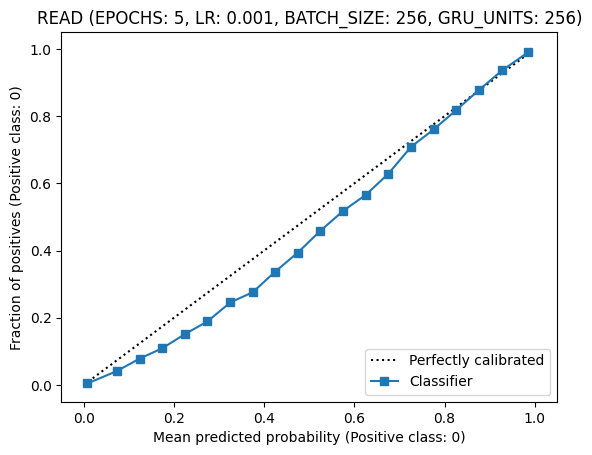

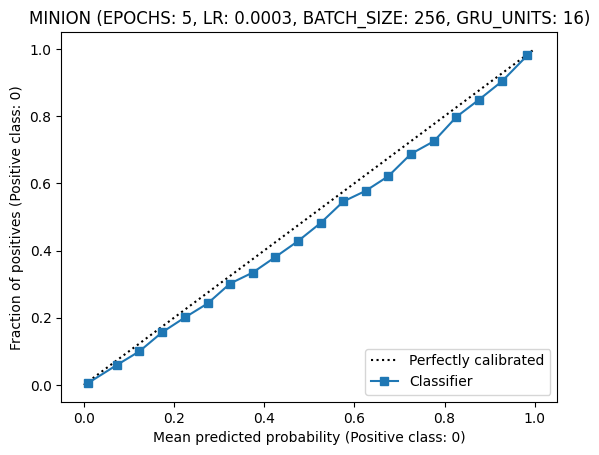

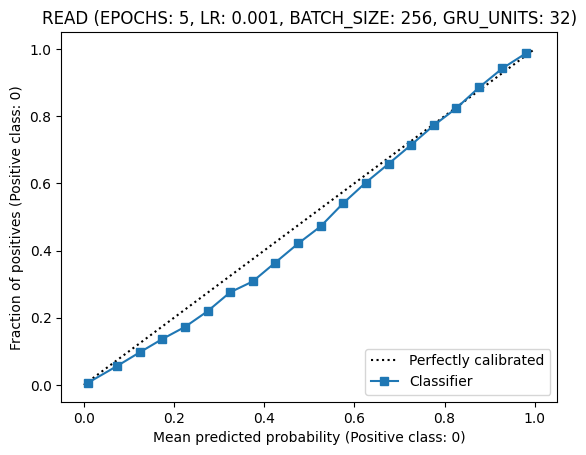

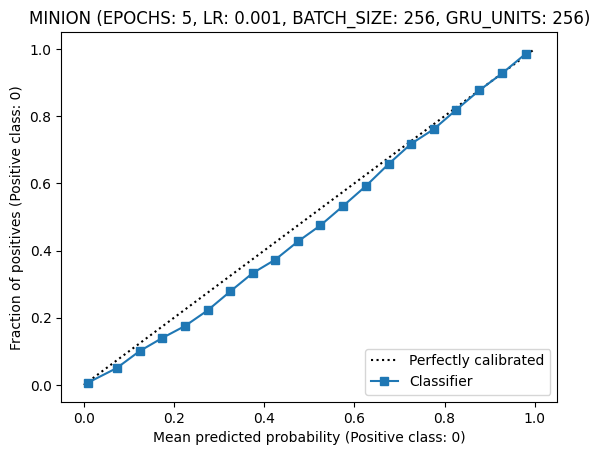

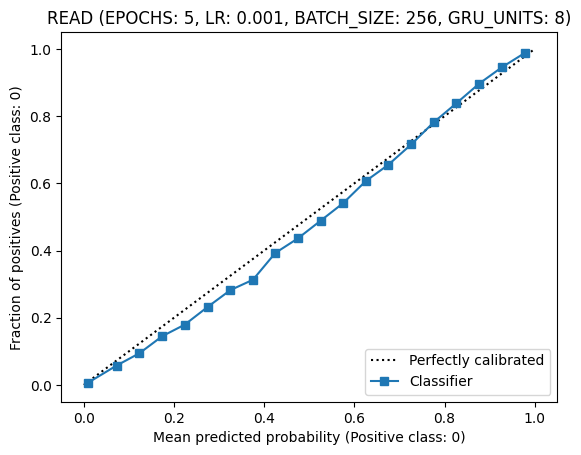

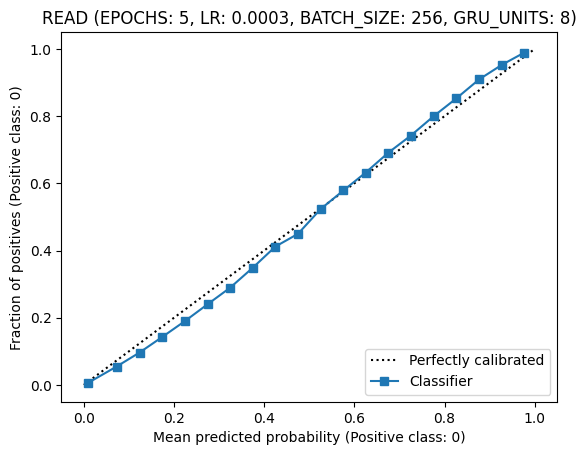

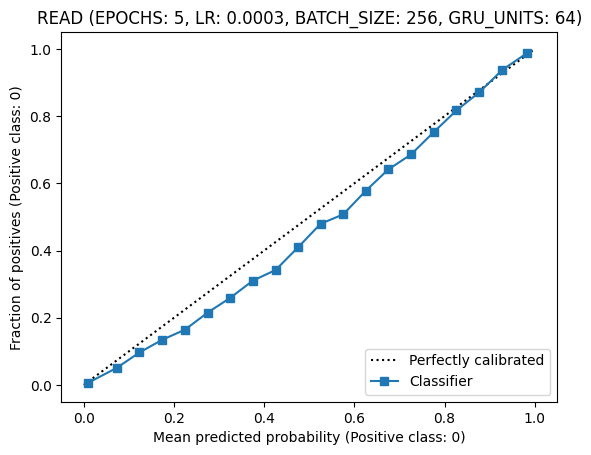

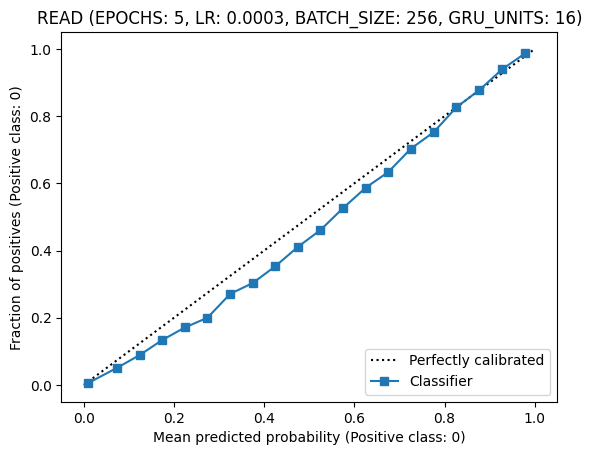

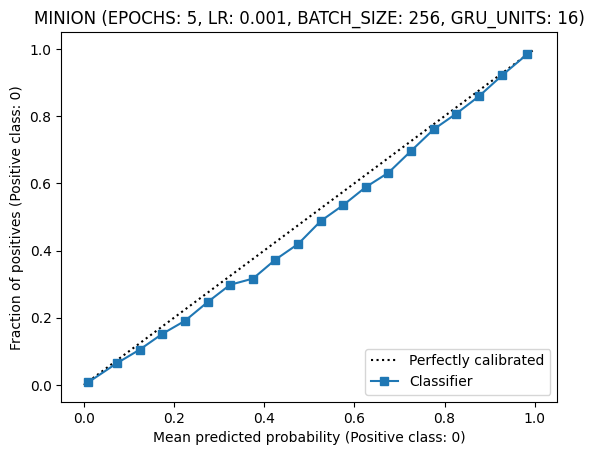

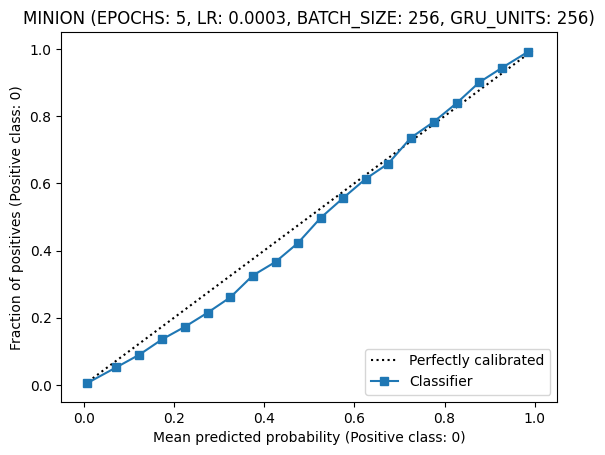

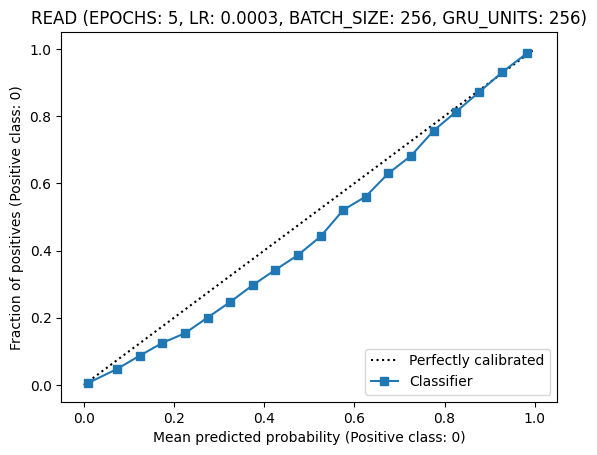

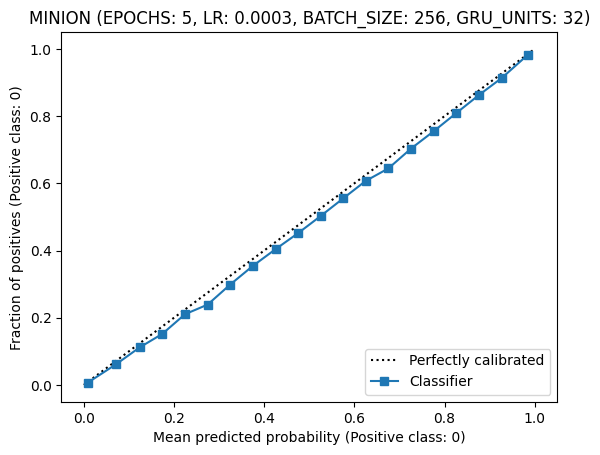

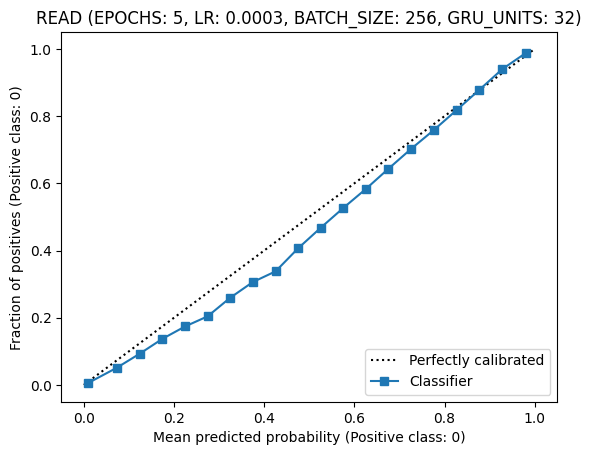

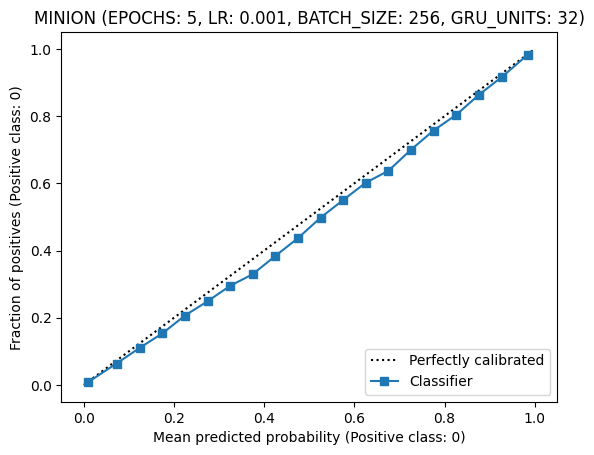

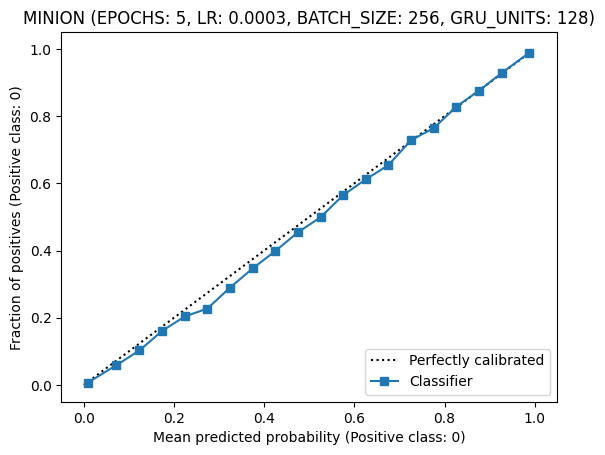

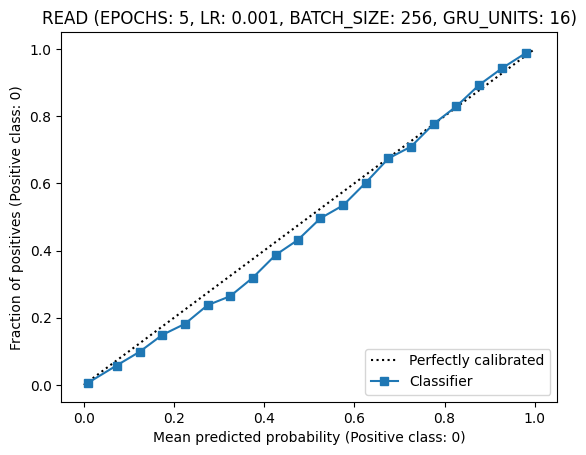

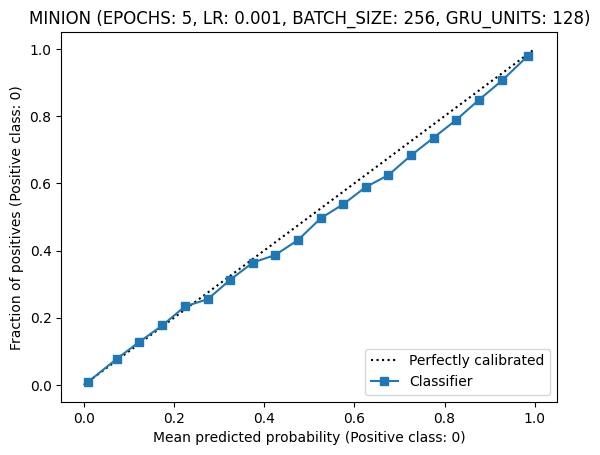

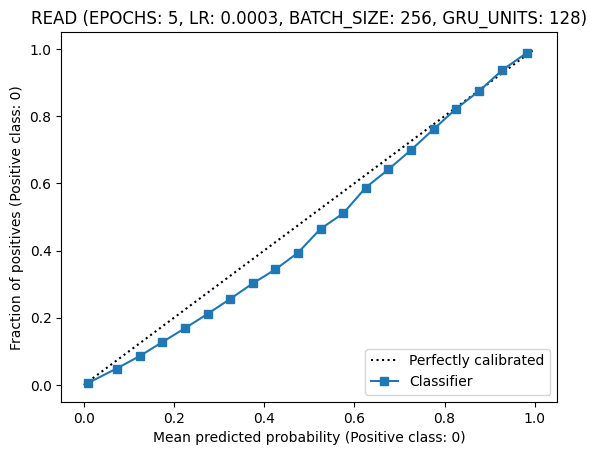

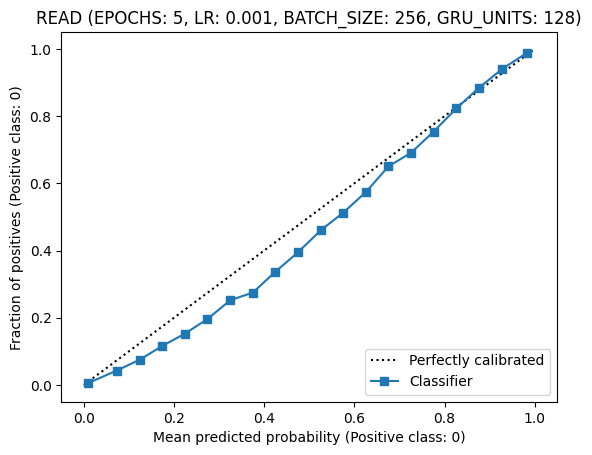

In [25]:
for experiment in EXPERIMENTS:
  get_calibration_display(experiment)

## GPU History

In [35]:
def plot_percent_values(datapoints,
                        interval,
                        y_axis_title='GPU Ressource utilization',
                        y_label='GPU Ressource utilization [%]',
                        plot_title='GPU Ressource utilization over Time'):
    # Create a range of time values in minutes
    time_values = np.arange(0, len(datapoints)*interval, interval) / 60

    # Create a DataFrame to hold time and percent values
    df = pd.DataFrame({
        'time [in min]': time_values,
        'GPU Ressource utilization': datapoints
    })

    # Create the plot
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df, x='time [in min]', y=y_axis_title)

    # Set titles
    plt.title(plot_title)
    plt.ylabel(y_label)
    plt.xlabel('time [in min]')

    # Display the plot
    plt.show()

def plot_mib_values(datapoints,
                        interval,
                        y_axis_title='GPU Memory utilization',
                        y_label='GPU Memory utilization [GiB]',
                        plot_title='GPU Ressource utilization over Time'):
    # Create a range of time values in minutes
    time_values = np.arange(0, len(datapoints)*interval, interval) / 60

    # scale datapoints to GiB
    # Define a conversion factor from MiB to GiB
    mib_to_gib_conversion = 1 / 1024
    # Create a new list to store the transformed data points in GiB
    data_points_gib = [data_point * mib_to_gib_conversion for data_point in datapoints]


    # Create a DataFrame to hold time and percent values
    df = pd.DataFrame({
        'time [in min]': time_values,
        'GPU Memory utilization': data_points_gib
    })

    # Create the plot
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df, x='time [in min]', y=y_axis_title)

    # Set titles
    plt.title(plot_title)
    plt.ylabel(y_label)
    plt.xlabel('time [in min]')

    # Display the plot
    plt.show()

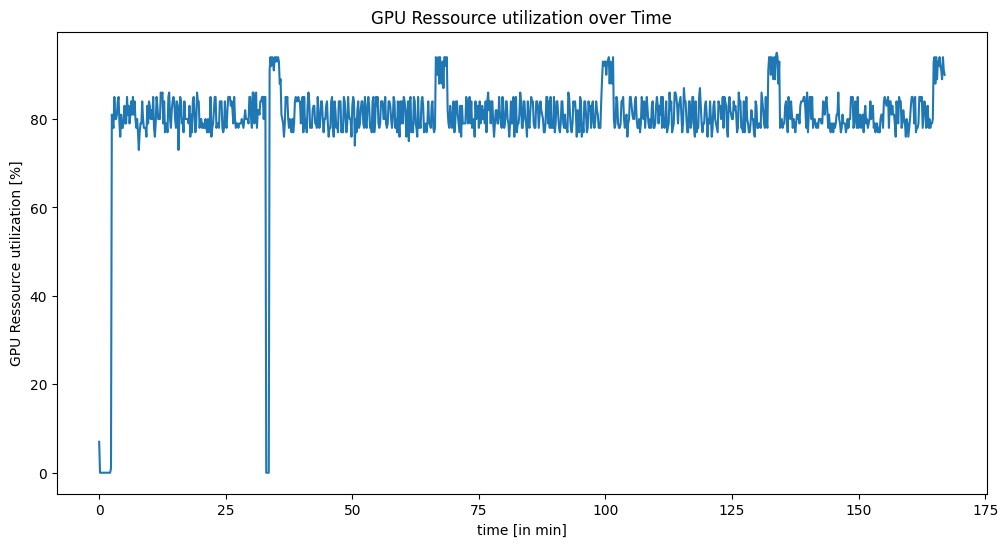

In [224]:
get_duration(experiment)
gpu_hist = experiment.gpu_history
plot_percent_values(datapoints=gpu_hist['percent'], interval=gpu_hist["interval"])

In [225]:
compute_energy_consumption(experiment)

0.8908888888888888

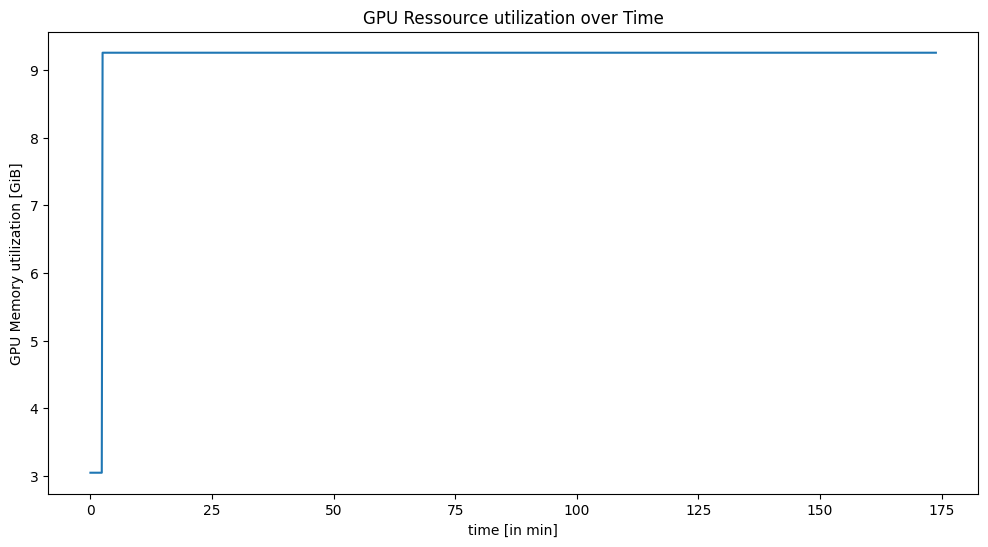

In [36]:
exp = get_experiment("basemodel")
gpu_hist = experiment.gpu_history

mibs = gpu_hist["mib"]
plot_mib_values(datapoints=gpu_hist['mib'], interval=gpu_hist["interval"])

## Experiment Duration


In [28]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def plot_experiment_durations(experiments):
    # sort first
    experiments = sort_experiments(experiments)

    # Create a list to store the experiment data
    experiment_data = []

    # Iterate over all the paths and load the experiment data
    for experiment in experiments:
        total_time_seconds, _, _, _ = get_duration(experiment)

        # Apply the transformation to the label
        label = experiment.description

        experiment_data.append({"Name": label, "Duration": total_time_seconds})

    # Convert the list to a DataFrame
    df = pd.DataFrame(experiment_data)

    # Ensure the 'Duration' column is numeric
    df['Duration'] = pd.to_numeric(df['Duration'], errors='coerce')

    print(df)

    # Create the seaborn plot
    plt.figure(figsize=(10,6))
    plot = sns.barplot(y="Name", x="Duration", data=df, orient="h")

    # Add labels for each bar
    #for i in range(df.shape[0]):
    #    plot.text(df.Duration[i], i, df.Name[i], color='black', ha="right")

    # Show the plot
    plt.xlabel('Duration')
    plt.ylabel('Experiment')
    plt.title('Training Durations')
    plt.show()


                                                 Name  Duration
0   BASE (EPOCHS: 5, LR: 2e-05, BATCH_SIZE: 256, G...   14660.0
1   READ (EPOCHS: 5, LR: 0.0003, BATCH_SIZE: 256, ...    9800.0
2   READ (EPOCHS: 5, LR: 0.001, BATCH_SIZE: 256, G...    9850.0
3   READ (EPOCHS: 5, LR: 0.0003, BATCH_SIZE: 256, ...    9740.0
4   READ (EPOCHS: 5, LR: 0.001, BATCH_SIZE: 256, G...    9800.0
5   READ (EPOCHS: 5, LR: 0.0003, BATCH_SIZE: 256, ...   10040.0
6   READ (EPOCHS: 5, LR: 0.001, BATCH_SIZE: 256, G...   10030.0
7   READ (EPOCHS: 5, LR: 0.0003, BATCH_SIZE: 256, ...    9910.0
8   READ (EPOCHS: 5, LR: 0.001, BATCH_SIZE: 256, G...    9890.0
9   READ (EPOCHS: 5, LR: 0.0003, BATCH_SIZE: 256, ...   10170.0
10  READ (EPOCHS: 5, LR: 0.001, BATCH_SIZE: 256, G...   10290.0
11  READ (EPOCHS: 5, LR: 0.0003, BATCH_SIZE: 256, ...   10800.0
12  READ (EPOCHS: 5, LR: 0.001, BATCH_SIZE: 256, G...   10790.0
13  MINION (EPOCHS: 5, LR: 0.0003, BATCH_SIZE: 256...    7670.0
14  MINION (EPOCHS: 5, LR: 0.001, BATCH_

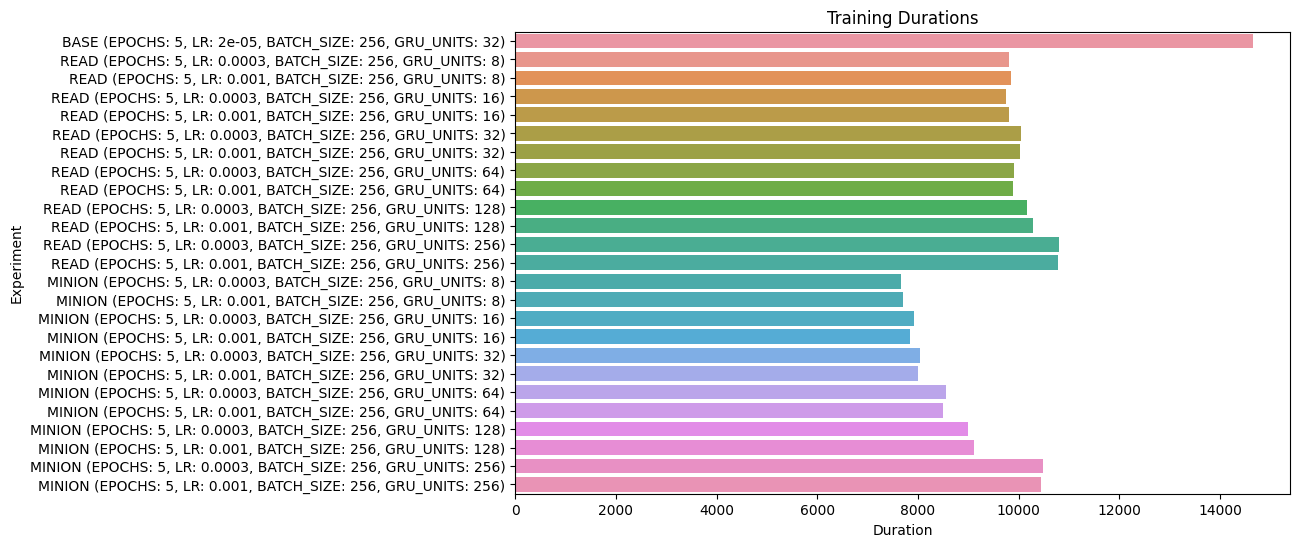

In [29]:
plot_experiment_durations(EXPERIMENTS)

## Other


In [46]:
import matplotlib.ticker as ticker
def generate_overview_plot(df):
    # Convert Learning Rate, Number of Units and Accuracy to numeric
    df['Learning Rate'] = pd.to_numeric(df['Learning Rate'])
    df['Number of Units'] = pd.to_numeric(df['Number of Units'])
    df['Accuracy'] = pd.to_numeric(df['Accuracy'])

    # Create a colormap for accuracy
    cmap = plt.get_cmap('YlGn')

    # Normalize the accuracy to range [0,1] for the colormap
    norm = plt.Normalize(df['Accuracy'].min(), df['Accuracy'].max())

    # Map model types to markers
    markers = {"BASE": "s", "READ": "o", "MINION": "^"}

    # Create a new figure
    fig, ax = plt.subplots(figsize=(10,10))

    # Create an empty list to store legend elements
    legend_elements = []

    # Iterate over each row in the dataframe to plot markers
    for index, row in df.iterrows():
        model_type = row['Model Type']
        lr = row['Learning Rate']
        units = row['Number of Units']
        accuracy = row['Accuracy']
        marker = markers[model_type]

        plt.scatter(lr, units, c=cmap(norm(accuracy)), marker=marker, s=100)

        # Add each unique model_type to the legend_elements list
        if model_type not in [i.get_label() for i in legend_elements]:
            legend_elements.append(plt.Line2D([0], [0], marker=marker, color='w', label=model_type,
                            markersize=10, markerfacecolor='black'))

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    fig.colorbar(sm)

    plt.title("Learning Rate vs Number of Units (with accuracy)")
    plt.xlabel("Learning Rate")
    plt.ylabel("Number of Units")

    # Format x-axis to scientific notation
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.0e'))

    # Add the legend to the plot
    ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=5)


    plt.show()


<ipython-input-46-4b7b77d1ade2>:31: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(lr, units, c=cmap(norm(accuracy)), marker=marker, s=100)
<ipython-input-46-4b7b77d1ade2>:40: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(sm)


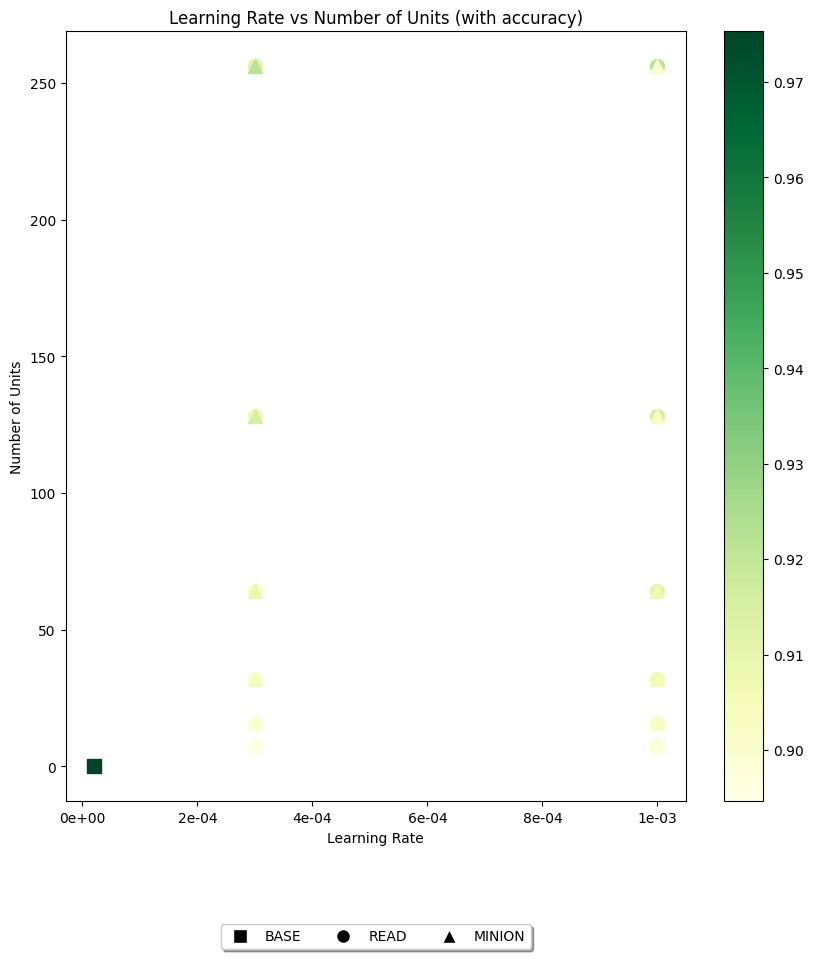

In [47]:
# Call the function with your DataFrame
experiment_df = create_experiment_dataframe(EXPERIMENTS)
generate_overview_plot(experiment_df)